Objective : To rank the likelihoods of a given player for liking a set of subjects

Solution :

We will follow the following approaches:


The data is divided into training and test-set:
Since the data is in a chronological order, we select the first 80% of the data for training set and the remaining 20% for testing set.

Facts about data:
- Imbalanced dataset
- About ~80% not likes

Approach 1:
- Use balanced Logistic Regression to get baseline performance.
- F1 weighted as scoring
- Evaluate using stratified cross-validation

Approach 2:
- Use XGBoost with Logistic Regression
- F1 weighted as scoring
- Evaluate using stratified cross-validation


In [34]:
#Add all the imports here
import numpy as np
import pandas as pd
from sklearn import pipeline, model_selection
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn import linear_model, decomposition
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
import itertools
import pickle

<body>Set parameters for Grid Search and Constants</body>

In [28]:
random_seed = 42
test_size = 0.20
iterations = [1000,5000,10000]
n_components = [10, 20, 29]
penalty = ['l1','l2']
class_names = ['dislike','like']
Cs = np.logspace(-4, 4, 3)
n_folds = 5
param_dist_pca_log = {"pca__n_components": n_components,
              "logistic__C": Cs, "logistic__penalty":penalty, "logistic__max_iter":iterations}
param_dist_svd_log = {"svd__n_components": n_components,
              "logistic__C": Cs, "logistic__penalty":penalty, "logistic__max_iter":iterations}
label_encoder = LabelEncoder()

<body>Define the Pipeline. Do dimensionality reduction using PCA and apply logistic regression</body>

In [3]:
logistic = linear_model.LogisticRegression(class_weight='balanced')
svd = TruncatedSVD()
pca = decomposition.PCA()
pipe_pca = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
pipe_svd = Pipeline(steps=[('svd', svd), ('logistic', logistic)])

Separate out the labels and drop the unnecessary columns

In [4]:
dataset = pd.read_csv('../../../data/processed_data.csv')
labels = dataset[['like']]
data = dataset.drop(['like','Unnamed: 0','player_id','subject_id'],axis=1)

Apply Encoding to Categorical variables

In [5]:
def encode_features(df, encoder):
        columnsToEncode = list(df.select_dtypes(include=['category','object']))
        for feature in columnsToEncode:
            try:
                df[feature] = encoder.fit_transform(df[feature])
            except:
                print('Error encoding '+feature)
        return df

In [6]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

Function for data preparation.
- Encode the data
- Divide the data into training and test set

In [7]:
def data_prep():
    data_label_encoded = encode_features(data, label_encoder)
    data_array = np.array(data_label_encoded)
    label_array = np.array(labels)
    X_train, X_test, y_train, y_test = train_test_split(data_array, labels, test_size=test_size, random_state=random_seed)
    return X_train, X_test, y_train, y_test

In [8]:
def random_search(n_iter, parameters, clf):
    n_iter_search = 2
    random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)
    random_search.fit(X_train, y_train)
    report(random_search.cv_results_)

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Running Grid Search on PCA and Logistic Regression

In [9]:
X_train, X_test, y_train, y_test = data_prep()

In [10]:
grid_search = model_selection.GridSearchCV(estimator = pipe_pca , 
                       param_grid = param_dist_pca_log, scoring='f1_weighted',n_jobs=4, cv=10)

In [11]:
grid_search.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'pca__n_components': [10, 20, 29], 'logistic__C': array([  1.00000e-04,   1.00000e+00,   1.00000e+04]), 'logistic__penalty': ['l1', 'l2'], 'logistic__max_iter': [1000, 5000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_weighted', verbose=0)

In [12]:
grid_search.best_params_, grid_search.best_score_

({'logistic__C': 10000.0,
  'logistic__max_iter': 10000,
  'logistic__penalty': 'l2',
  'pca__n_components': 29},
 0.82345948875191166)

In [15]:
with open('../models/logistic_regression_pca', "wb") as fp:
    pickle.dump(grid_search, fp)

In [18]:
y_scores = grid_search.best_estimator_.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

In [32]:
print(auc(y_test, y_scores, reorder=True))
print(auc(precision, recall, reorder=True))
y_predict = grid_search.best_estimator_.predict(X_test)
confusion_matrix_pca_logistic = confusion_matrix(y_test, y_predict)

0.503363110511
0.433374222323


Confusion matrix, without normalization
[[67806 14647]
 [ 4519 13181]]


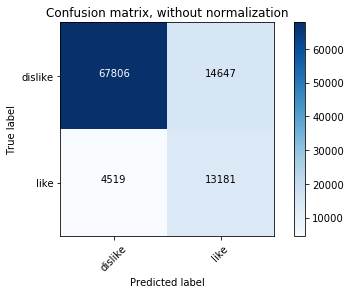

In [36]:
plt.figure()
plot_confusion_matrix(confusion_matrix_pca_logistic, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

Running Grid Search on SVD and Logistic Regression

In [37]:
grid_search_svd = model_selection.GridSearchCV(estimator = pipe_svd , 
                       param_grid = param_dist_svd_log, scoring='f1_weighted',n_jobs=4, cv=10)

In [ ]:
grid_search_svd.fit(X_train, y_train.values.ravel())

In [ ]:
with open('../models/logistic_regression_svd', "wb") as fp:
    pickle.dump(grid_search_svd, fp)
y_scores = grid_search_svd.best_estimator_.predict_proba(X_test)[:,1]
y_predict = grid_search_svd.best_estimator_.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

In [ ]:
print(auc(y_test, y_scores, reorder=True))
print(auc(precision, recall, reorder=True))
confusion_matrix_pca_logistic = confusion_matrix(y_test, y_predict)

In [ ]:
plt.figure()
plot_confusion_matrix(confusion_matrix_pca_logistic, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()